In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc


df = pd.read_csv('datasets/daily_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')
df

,open,high,low,close,adjclose,volume,ticker
date,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.122364,1003200,SPY
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.301012,480500,SPY
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.354612,201300,SPY
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.622643,529400,SPY
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.729851,531500,SPY
...,...,...,...,...,...,...,...
2023-05-02,414.769989,414.820007,407.820007,410.839996,410.839996,103998500,SPY
2023-05-03,411.359985,413.869995,407.769989,408.019989,408.019989,91531800,SPY
2023-05-04,406.929993,407.269989,403.739990,405.130005,405.130005,94901900,SPY


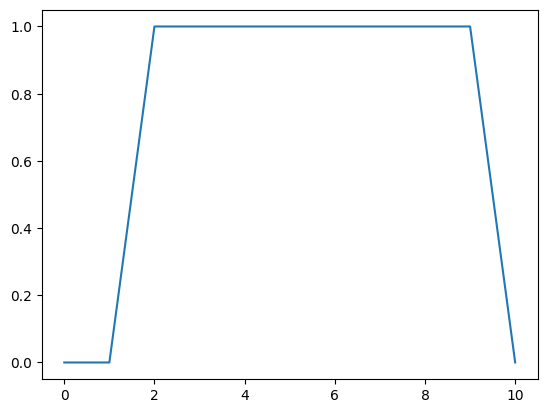

array([ 0,  1,  0,  0,  0,  0,  0,  0,  0, -1])

In [28]:
def generate_random_orders(length, threshold=0.1):
    random_positions = np.array([0 if f <= threshold else 1 for f in np.random.rand(length - 1)])
    random_positions = np.insert(random_positions, 0, 0)
    random_positions = np.insert(random_positions,len(random_positions), 0)
    plt.plot(random_positions)
    plt.show()
    random_orders = random_positions[1:] - random_positions[:-1]
    assert len(random_orders) == length
    return random_orders

generate_random_orders(10)

                  open        high         low       close    adjclose  \
date                                                                     
1993-01-29   43.968750   43.968750   43.750000   43.937500   25.122364   
1993-02-01   43.968750   44.250000   43.968750   44.250000   25.301012   
1993-02-02   44.218750   44.375000   44.125000   44.343750   25.354612   
1993-02-03   44.406250   44.843750   44.375000   44.812500   25.622643   
1993-02-04   44.968750   45.093750   44.468750   45.000000   25.729851   
...                ...         ...         ...         ...         ...   
2023-05-02  414.769989  414.820007  407.820007  410.839996  410.839996   
2023-05-03  411.359985  413.869995  407.769989  408.019989  408.019989   
2023-05-04  406.929993  407.269989  403.739990  405.130005  405.130005   
2023-05-05  408.910004  413.720001  408.640015  412.630005  412.630005   
2023-05-08  412.970001  413.100006  411.679993  412.659393  412.659393   

               volume ticker    signa

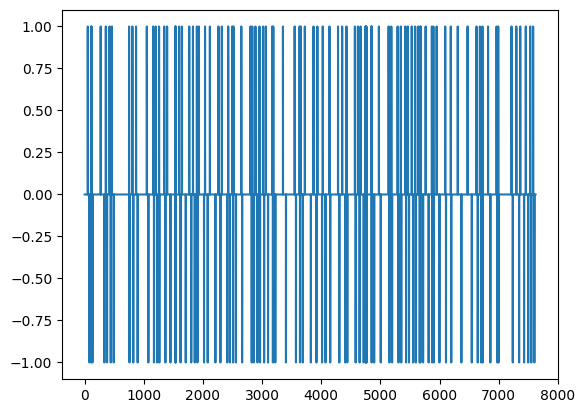

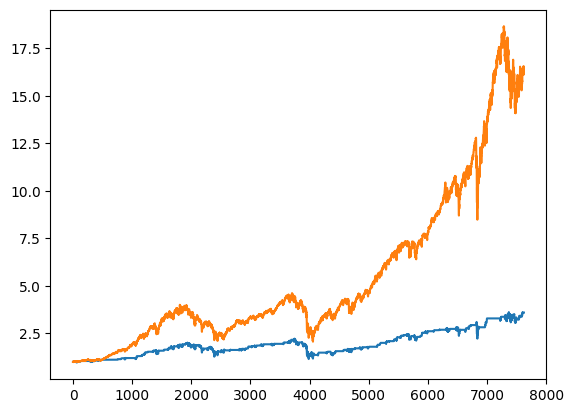

In [29]:
class trade:
    def __init__(self, entry_date, entry_price, quantity):
        self.entry_date = entry_date
        self.entry_price = entry_price
        self.quantity = quantity
        self.is_open = True
        if quantity > 0:
            self.is_long = True
        else:
            self.is_long = False
    
    def close(self, exit_date, exit_price):
        self.exit_date = exit_date
        self.exit_price = exit_price
        self.is_open = False

    def calculate_stats(self):
        self.profit = self.quantity * (self.exit_price - self.entry_price)
        self.returns = self.profit / abs(self.entry_price * self.quantity)
        self.time_in_trade = self.exit_date - self.entry_date
        self.capital_at_risk = abs(self.entry_price) * self.quantity
        # max drawdown
        # potential profit

def generate_record(trade_list):
    df = {
        'profit': np.array([f.profit for f in trade_list]),
        'returns': np.array([f.returns for f  in trade_list]),
        'time_in_trade': np.array([f.time_in_trade.days for f in trade_list]),
        'entry_date': np.array([f.entry_date for f in trade_list]),
        'exit_date': np.array([f.exit_date for f in trade_list]),
        'quantity': np.array([f.quantity for f in trade_list]),
        'capital_at_risk': np.array([f.capital_at_risk for f in trade_list])
    }
    df = pd.DataFrame.from_dict(df)

    return df

class tradeList:
    def __init__(self):
        self.list = []

    def append(self, trade):
        self.list.append(trade)

    def analyse(self):
        self.list = [f for f in self.list if f.is_open==False]

        for trade in self.list:
            trade.calculate_stats()
        
        self.win_list = [f for f in self.list if f.profit > 0]
        self.loss_list = [f for f in self.list if f.profit <= 0]

        self.records = generate_record(self.list)
        self.win_records = generate_record(self.win_list)
        self.loss_records = generate_record(self.loss_list)

        self.stats = {
            'num_wins': len(self.win_list),
            'num_loss': len(self.loss_list),
            'win_rate': len(self.win_list) / (len(self.win_list) + len(self.loss_list)),
            'profit': self.records['profit'].sum(),
            'profit_mean': self.records['profit'].mean(),
            'returns_mean': self.records['returns'].mean(),
            'returns_std': self.records['returns'].std(),
            'time_in_trade_mean': self.records['time_in_trade'].mean(),
            'time_in_trade_std': self.records['time_in_trade'].std(),
            'capital_at_risk_mean': self.records['capital_at_risk'].mean(),
            'win_returns_mean': self.win_records['returns'].mean(),
            'win_returns_std': self.win_records['returns'].std(),
            'win_profit_mean': self.win_records['profit'].mean(),
            'win_time_in_trade_mean': self.win_records['time_in_trade'].mean(),
            'win_time_in_trade_std': self.win_records['time_in_trade'].std(),
            'loss_returns_mean': self.loss_records['returns'].mean(),
            'loss_returns_std': self.loss_records['returns'].std(),
            'loss_profit_mean': self.loss_records['profit'].mean(),
            'loss_time_in_trade_mean': self.loss_records['time_in_trade'].mean(),
            'loss_time_in_trade_std': self.loss_records['time_in_trade'].std(),
            
        }

        self.records = pd.DataFrame.from_dict(self.records)

    

class backtester:
    def __init__(self, **kwargs) -> None:
        self.df = None
        self.initial_capital = misc.get_attr(kwargs, 'initial_capital', 1E6)
        self.reward_function = misc.get_attr(kwargs, 'reward_function', None)
        self.mode = misc.get_attr(kwargs, 'mode', 'trading')

        
        self.clean_slate()

        


    def clean_slate(self):
        '''
        Set initial default state of environment.
        Called by __init__ and reset
        '''
        # State variables
        self.cash = self.initial_capital
        self.position = 0
        self.position_value = 0
        self.portfolio_value = self.cash + self.position_value
        self.leverage = abs(self.position_value / self.portfolio_value)
        self.portfolio_volatility = 0
        self.portfolio_return = 1
        self.end = False
        self.current_step = 0
        self.open_trade = None

        # record all instantaneous values of state
        self.record = {
            'cash': [],
            'position': [],
            'position_value': [],
            'portfolio_value': [],
            'leverage': [],
        }

        # record all trades
        self.trade_record = tradeList()

        # instantaneous state of the trader
        self.trader_state = np.array([
            self.cash,
            self.position,
            self.position_value,
            self.portfolio_value,
            # self.leverage,
        ])



    def set_asset(self, df):
        self.df = df

        self.open = self.df['open'].to_numpy()
        self.high = self.df['high'].to_numpy()
        self.low = self.df['low'].to_numpy()
        self.close = self.df['close'].to_numpy()
        self.adjclose = self.df['adjclose'].to_numpy()
        self.date = self.df.index.to_list()



    def take_action(self, order_quantity=0, order_price=0, order_type='market_on_close'):
        execution_price = 0
        execution_quantity = 0
        # price at which to evaluate position
        evaluation_price = self.adjclose[self.current_step]
        if order_quantity == 0:
            pass
        else:
            
            if order_type == 'market_on_close':
                execution_price = self.adjclose[self.current_step]
                execution_quantity = order_quantity
            
            if self.mode == 'trading':
                # record trades
                if self.open_trade == None:
                    assert self.position == 0, 'no open trades but position != 0'
                    # opening new trade
                    self.cost_basis = execution_price
                    self.open_trade = trade(self.date[self.current_step], execution_price, execution_quantity)
                else:
                    # close trade
                    self.open_trade.close(self.date[self.current_step], execution_price)
                    self.trade_record.append(self.open_trade)
                    self.open_trade = None

            elif self.mode == 'portfolio_optimisation':
                pass
                
            
            self.position += execution_quantity
            self.cash -= execution_price * execution_quantity

        # calculate new trader state
        self.position_value = self.position * evaluation_price
        self.portfolio_value = self.cash + self.position_value
        self.leverage = abs(self.position_value / self.portfolio_value)

        self.trader_state = np.array([
            self.cash,
            self.position,
            self.position_value,
            self.portfolio_value,
            # self.leverage,
            # self.portfolio_volatility,
        ])

        # record
        self.record['cash'].append(self.cash)
        self.record['position'].append(self.position)
        self.record['position_value'].append(self.position_value)
        self.record['portfolio_value'].append(self.portfolio_value)
        self.record['leverage'].append(self.leverage)

        self.current_step += 1

        if self.current_step == len(self.df):
            print('end')

    def results_analysis(self):
        self.results = pd.DataFrame.from_dict(self.record)
        self.results['date'] = self.date
        self.results = self.results.set_index('date')
        self.results['returns'] = self.results['portfolio_value'].pct_change()
        self.results['cumulative_returns'] = (self.results['portfolio_value'] 
                                              / self.results['portfolio_value'][0])
        



    
bt = backtester()

df = pd.read_csv('datasets/daily_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')

bt.set_asset(df.copy())

df['signal'] = df['close'].rolling(13).mean() - df['close'].rolling(48).mean()
df['signal+1'] = df['signal'].shift(1)

trade_list = []
for i in range(len(df)):
    if df['signal'][i] < 0 and df['signal+1'][i] > 0:
        trade_list.append(1)
    elif df['signal'][i] > 0 and df['signal+1'][i] < 0:
        trade_list.append(-1)
    else:
        trade_list.append(0)

df['trade_list'] = trade_list

print(df)



for i in trade_list:
    if bt.open_trade == None:
        order_quantity = (bt.cash // bt.adjclose[bt.current_step]) * trade_list[bt.current_step]
    else:
        order_quantity = bt.position * trade_list[bt.current_step]

    bt.take_action(order_quantity=order_quantity)

port_val = np.array(bt.record['portfolio_value']) / 1e6

pos = np.array(bt.record['position'])

plt.plot(trade_list)
# plt.plot(pos/np.max(pos))
plt.show()


plt.plot(port_val)
plt.plot(bt.df['adjclose'].to_numpy() / 25.122364)

<Axes: xlabel='date'>

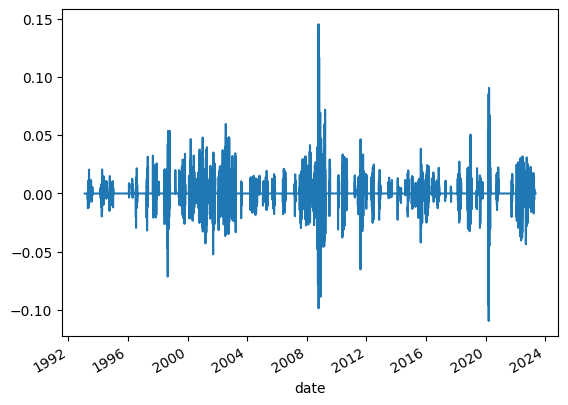

In [30]:
bt.results_analysis()
bt.results['returns'].plot()



In [31]:
bt.trade_record.analyse()
bt.trade_record.stats

{'num_wins': 75,
 'num_loss': 17,
 'win_rate': 0.8152173913043478,
 'profit': 2590516.262899401,
 'profit_mean': 28157.78546629784,
 'returns_mean': 0.015160934727326181,
 'returns_std': 0.04684451737433408,
 'time_in_trade_mean': 41.57608695652174,
 'time_in_trade_std': 33.02088373350728,
 'capital_at_risk_mean': 1943882.46300886,
 'win_returns_mean': 0.031146258998202406,
 'win_returns_std': 0.022346773895574254,
 'win_profit_mean': 60233.74443560285,
 'win_time_in_trade_mean': 30.14666666666667,
 'win_time_in_trade_std': 20.471267493557715,
 'loss_returns_mean': -0.05536255470301012,
 'loss_returns_std': 0.06073603189286792,
 'loss_profit_mean': -113353.79822181247,
 'loss_time_in_trade_mean': 92.0,
 'loss_time_in_trade_std': 30.813957876261206}

<Axes: >

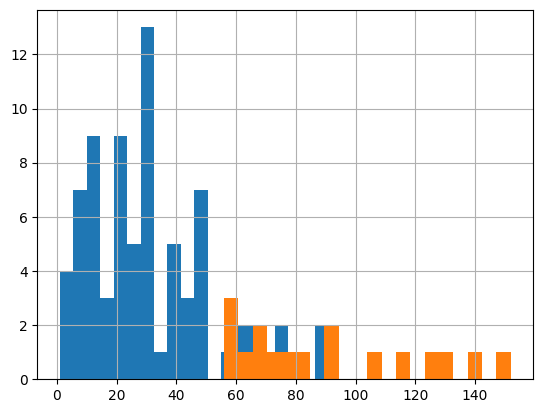

In [32]:
bt.trade_record.win_records['time_in_trade'].hist(bins=20)
bt.trade_record.loss_records['time_in_trade'].hist(bins=20)